# Simulators


## Introduction

This notebook shows how to import the *Qiskit Aer* simulator backend and use it to execute ideal (noise free) Qiskit Terra circuits.

In [1]:
import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi

## The AerProvider
 
The `Aer` provider contains a variety of high performance simulator backends for a variety of simulation methods. The available backends on the current system can be viwed using `Aer.backends`

In [2]:
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

## The AerSimulator
 
The main simulator backend of the Aer provider is the `AerSimulator` backend. A new simulator backend can be created using `Aer.get_backend('aer_simulator')`.

In [3]:
simulator = Aer.get_backend('aer_simulator')

The default behavior of teh `AerSimulator` backend is to mimic the execution of an actual device. If a `QuantumCircuit` containing measurements is run it will return a count dictionary containing the final values of any classical registers in the circuit. The circuit may contain gates, measurements, resets, conditionals, and other custom simulator instructions that will be discussed in another notebook.

### Simulating a quantum circuit

The basic operation executes a quantum circuit and returns a counts dictionary of measurement outcomes. Here we execute a simple circuit that prepares a 2-qubit Bell-state $|\psi\rangle = \frac{1}{2}(|0,0\rangle + |1,1 \rangle)$ and measures both qubits.

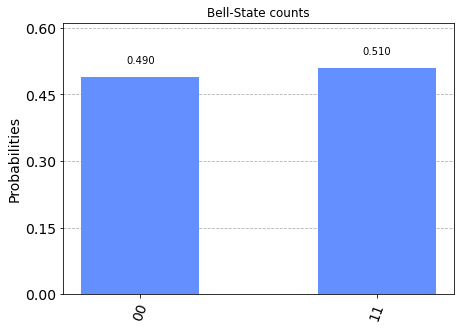

In [4]:
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.measure_all()

# Execute and get counts
result = execute(circ, simulator).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

### Returning measurement outcomes for each shot

The `QasmSimulator` also supports returning a list of measurement outcomes for each individual shot. This is enabled by setting the keyword argument `memory=True` in the `assemble` or `execute` function.

In [5]:
# Execute and get memory
result = execute(circ, simulator, shots=10, memory=True).result()
memory = result.get_memory(circ)
print(memory)

['00', '00', '00', '11', '00', '00', '11', '11', '00', '00']


## Simulation Method

The `AerSimulator` supports a variety of simulation methods, each of which supports a different set of instructions. 

The default simulation method is `"automatic"` which will automatically select a one of the other simulation methods for each executed circuit based on the instructions in those circuits. A fixed simualtion method can be specified by by adding the method name when getting the backend, or by setting the `method` option on the backend.

When simulating ideal circuits, changing the method between the exact simulation methods `"stabilizer"`, `"statevector"`, `"density_matrix"` and `"matrix_product_state"` should not change the simulation result (other than usual variations from sampling probabilities for measurement outcomes)

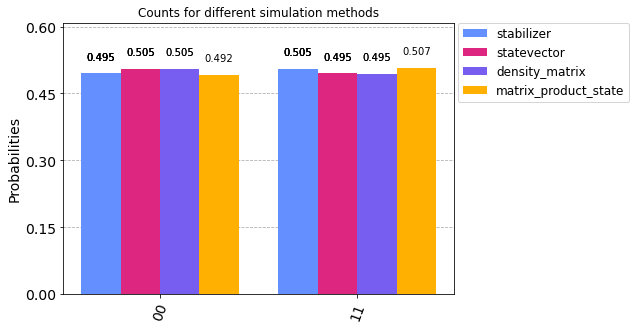

In [6]:
# Increase shots to reduce sampling variance
shots = 10000

# Stabilizer simulation method
sim_stabilizer = Aer.get_backend('aer_simulator_stabilizer')
job_stabilizer = execute(circ, sim_stabilizer, shots=shots)
counts_stabilizer = job_stabilizer.result().get_counts(0)

# Statevector simulation method
sim_statevector = Aer.get_backend('aer_simulator_statevector')
job_statevector = execute(circ, sim_statevector, shots=shots)
counts_statevector = job_statevector.result().get_counts(0)

# Density Matrix simulation method
sim_density = Aer.get_backend('aer_simulator_density_matrix')
job_density = execute(circ, sim_density, shots=shots)
counts_density = job_density.result().get_counts(0)

# Matrix Product State simulation method
sim_mps = Aer.get_backend('aer_simulator_matrix_product_state')
job_mps = execute(circ, sim_mps, shots=shots)
counts_mps = job_mps.result().get_counts(0)

plot_histogram([counts_stabilizer, counts_statevector, counts_density, counts_mps],
               title='Counts for different simulation methods',
               legend=['stabilizer', 'statevector',
                       'density_matrix', 'matrix_product_state'])

## Saving the simulator state

The state of the simulator can be saved in a variety of formats using custom simulator instructions.


| Circuit method | Description |Supported Methods | 
|----------------|-------------|------------------|
| `save_state` | Save the simulator state in the native format for the simulation method | All | 
| `save_statevector` | Save the simulator state as a statevector | `"automatic"`, `"statevector"`, `"matrix_product_state"`, `"extended_stabilizer"`|
| `save_stabilizer` | Save the simulator state as a Clifford stabilizer | `"automatic"`, `"stabilizer"`| 
| `save_density_matrix` | Save the simulator state as a density matrix | `"automatic"`, `"statevector"`, `"matrix_product_state"`, `"density_matrix"` |
| `save_matrix_product_state` | Save the simulator state as a a matrix product state tensor | `"automatic"`, `"matrix_product_state"`|
| `save_unitary` | Save the simulator state as unitary matrix of the run circuit | `"automatic"`, `"unitary"`|
| `save_superop` | Save the simulator state as superoperator matrix of the run circuit | `"automatic"`, `"superop"`|

Note that these instructions are only supported by the Aer simulator and will result in an error if a circuit containing them is run on a non-simulator backend such as an IBM Quantum device.

### Saving the final statevector

To save the final statevector of the simulation we can append the circuit with the `save_statevector` instruction. Note that this instruction should be applied *before* any measurements if we do not want to save the collapsed post-measurement state

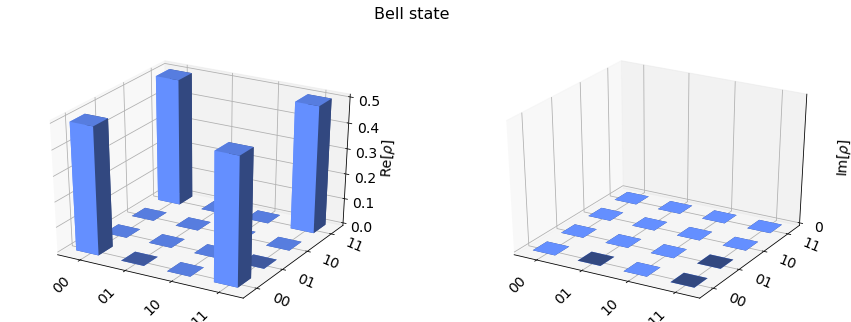

In [7]:
# Construct quantum circuit without measure
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.save_statevector()

# Execute and get statevector
result = execute(circ, simulator).result()
statevector = result.get_statevector(circ)
plot_state_city(statevector, title='Bell state')

### Saving the circuit unitary

To save the unitary matrix for a `QuantumCircuit` we can append the circuit with the `save_unitary` instruction. Note that this circuit cannot contain any measurements or resets since these instructions are not suppored on for the `"unitary"` simulation method

In [8]:
# Construct quantum circuit without measure
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.save_unitary()

# Execute and get unitary
result = execute(circ, simulator).result()
unitary = result.get_unitary(circ)
print("Circuit unitary:\n", unitary.round(5))

Circuit unitary:
 [[ 0.70711+0.j  0.70711-0.j  0.     +0.j  0.     +0.j]
 [ 0.     +0.j  0.     +0.j  0.70711+0.j -0.70711+0.j]
 [ 0.     +0.j  0.     +0.j  0.70711+0.j  0.70711-0.j]
 [ 0.70711+0.j -0.70711+0.j  0.     +0.j  0.     +0.j]]


### Saving multiple states

We can also apply save instructions at multiple locations in a circuit. Note that when doing this we must provide a unique label for each instruction to retrieve them from the results

In [9]:
# Construct quantum circuit without measure
steps = 5
circ = QuantumCircuit(1)
for i in range(steps):
    circ.save_statevector(label=f'psi_{i}')
    circ.rx(i * np.pi / steps, 0)
circ.save_statevector(label=f'psi_{steps}')

# Execute and get saved data
result = execute(circ, simulator).result()
data = result.data(0)
data

{'psi_3': array([0.58778525+0.j        , 0.        -0.80901699j]),
 'psi_2': array([0.95105652+0.j        , 0.        -0.30901699j]),
 'psi_5': array([-1.+0.00000000e+00j,  0.-2.77555756e-16j]),
 'psi_1': array([1.+0.j, 0.+0.j]),
 'psi_4': array([-0.30901699+0.j        ,  0.        -0.95105652j]),
 'psi_0': array([1.+0.j, 0.+0.j])}

## Setting the simulator to a custom state

The `AerSimulator` allows setting a custom simulator state for several of its simulation methods using custom simulator instructions

| Circuit method | Description |Supported Methods | 
|----------------|-------------|------------------|
| `set_statevector` | Set the simulator state to the specified statevector | `"automatic"`, `"statevector"`, `"density_matrix"`|
| `set_stabilizer` | Set the simulator state to the specified Clifford stabilizer | `"automatic"`, `"stabilizer"`| 
| `set_density_matrix` | Set the simulator state to the specified  density matrix | `"automatic"`, `"density_matrix"` |
| `set_unitary` | Set the simulator state to the specified  unitary matrix | `"automatic"`, `"unitary"`, `"superop"`|
| `set_superop` | Set the simulator state to the specified superoperator matrix | `"automatic"`, `"superop"`|


**Notes:**
* These instructions must be applied to all qubits in a circuit, otherwise an exception will be raised.
* The input state must also be a valid state (statevector, denisty matrix, unitary etc) otherwise an exception will be raised.
* These instructions can be applied at any location in a circuit and will override the current state with the specified one. Any classical register values (eg from preceeding measurements) will be unaffected
* Set state instructions are only supported by the Aer simulator and will result in an error if a circuit containing them is run on a non-simulator backend such as an IBM Quantum device.

### Setting a custom statevector

The `set_statevector` instruction can be used to set a custom `Statevector` state. The input statevector must be valid ($|\langle\psi|\psi\rangle|=1$)

In [10]:
num_qubits = 2
psi = qi.random_statevector(2 ** num_qubits, seed=100)
circ = QuantumCircuit(num_qubits)
circ.set_statevector(psi)
circ.save_state()

result = execute(circ, simulator).result()
result.data(0)

{'statevector': array([ 0.18572453-0.03102771j, -0.26191269-0.18155865j,
         0.12367038-0.47837907j,  0.66510011-0.4200986j ])}

#### Using the initialize instruction

It is also possible to initialize the simulator to a custom statevector using the `initialize` instruction. Unlike the `set_statevector` instruction this instruction is also supported on real device backends by unrolling to reset and standard gate instructions.

In [11]:
circ = QuantumCircuit(num_qubits)
circ.initialize(psi, range(num_qubits))
circ.save_state()

result = execute(circ, simulator).result()
result.data(0)

{'statevector': array([ 0.18572453-0.03102771j, -0.26191269-0.18155865j,
         0.12367038-0.47837907j,  0.66510011-0.4200986j ])}

### Setting a custom density matrix

The `set_density_matrix` instruction can be used to set a custom `DensityMatrix` state. The input density matrix must be valid ($Tr[\rho]=1, \rho \ge 0$)

In [12]:
num_qubits = 2
rho = qi.random_density_matrix(2 ** num_qubits, seed=100)
circ = QuantumCircuit(num_qubits)
circ.set_density_matrix(rho)
circ.save_state()

result = execute(circ, simulator).result()
result.data(0)

{'density_matrix': array([[ 0.2075308 -3.11427124e-18j,  0.13161422-1.76084787e-02j,
          0.0442826 +7.74270413e-02j,  0.04852053-1.30317117e-02j],
        [ 0.13161422+1.76084787e-02j,  0.20106116-2.89376869e-18j,
          0.02568549-3.68981173e-02j,  0.0482903 -4.36791212e-02j],
        [ 0.0442826 -7.74270413e-02j,  0.02568549+3.68981173e-02j,
          0.39731492+6.09745953e-18j, -0.01114025-1.34264228e-01j],
        [ 0.04852053+1.30317117e-02j,  0.0482903 +4.36791212e-02j,
         -0.01114025+1.34264228e-01j,  0.19409312-8.94195941e-20j]])}

### Setting a custom stabilizer state

The `set_stabilizer` instruction can be used to set a custom `Clifford` stabilizer state. The input stabilizer must be a valid `Clifford`.

In [13]:
num_qubits = 2
stab = qi.random_clifford(num_qubits, seed=100)
circ = QuantumCircuit(num_qubits)
circ.set_stabilizer(stab)
circ.save_state()

result = execute(circ, simulator).result()
result.data(0)

{'stabilizer': {'destabilizer': ['-XZ', '-YX'], 'stabilizer': ['+ZZ', '-IZ']}}

### Setting a custom unitary

The `set_unitary` instruction can be used to set a custom unitary `Operator` state. The input unitary matrix must be valid ($U^\dagger U=\mathbb{1}$)

In [14]:
num_qubits = 2
unitary = qi.random_unitary(2 ** num_qubits, seed=100)
circ = QuantumCircuit(num_qubits)
circ.set_unitary(unitary)
circ.save_state()

result = execute(circ, simulator).result()
result.data(0)

{'unitary': array([[-0.44885724-0.26721573j,  0.10468034-0.00288681j,
          0.4631425 +0.15474915j, -0.11151309-0.68210936j],
        [-0.37279054-0.38484834j,  0.3820592 -0.49653433j,
          0.14132327-0.17428515j,  0.19643043+0.48111423j],
        [ 0.2889092 +0.58750499j,  0.39509694-0.22036424j,
          0.49498355+0.2388685j ,  0.25404989-0.00995706j],
        [ 0.01830684+0.10524311j,  0.62584001+0.01343146j,
         -0.52174025-0.37003296j,  0.12232823-0.41548904j]])}

In [15]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

/Users/cjwood/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/aqua/operators/operator_globals.py:48: DeprecationWarning: `from_label` is deprecated and will be removed no earlier than 3 months after the release date. Use Pauli(label) instead.
  X = make_immutable(PrimitiveOp(Pauli.from_label('X')))
